# Phase detection
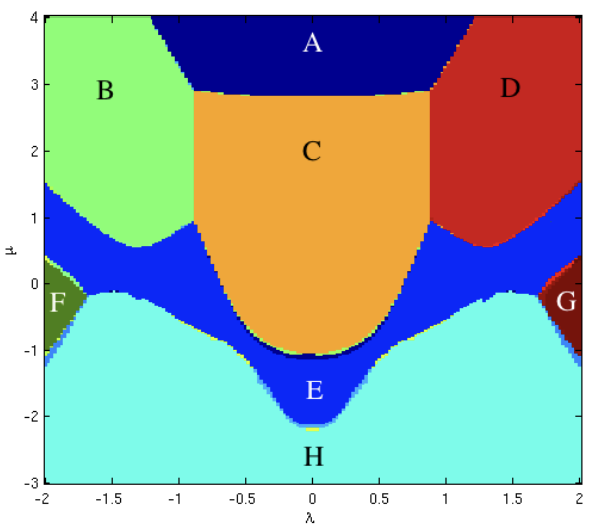

## Phase transition from B, C, to D 

In [1]:
# General overview of measurement https://tenpy.readthedocs.io/en/latest/intro/measurements.html
from tenpy.networks.site import SpinSite
from tenpy.networks.mps import TransferMatrix
from tenpy.linalg import np_conserved as npc
import numpy as np
from tenpy.networks.mps import MPS
import h5py
from tenpy.tools import hdf5_io
import glob
import numpy as np
import matplotlib.pyplot as plt
import tenpy.linalg as npc
from analysis_tools import MPS_drop_charge, check_onsite_symmetry, list_contract, fix_norm, check_A4_class

In [2]:
path_phaseC = './results/dmrg_A4SpinChain_chi_0100_L_2.000_lamb_-0.001_mu_2.000.h5'
path_phaseB = './results/dmrg_A4SpinChain_chi_0100_L_2.000_lamb_-1.163_mu_2.000.h5'
path_phaseD = './results/dmrg_A4SpinChain_chi_0100_L_2.000_lamb_1.108_mu_2.000.h5'

In [3]:
fphaseC = h5py.File(path_phaseC)
fphaseB = h5py.File(path_phaseB)
fphaseD = h5py.File(path_phaseD)
dphaseC = hdf5_io.load_from_hdf5(fphaseC)
dphaseB = hdf5_io.load_from_hdf5(fphaseB)
dphaseD = hdf5_io.load_from_hdf5(fphaseD)

In [4]:
Sx = SpinSite(S=1,conserve='None').Sx
Sy = SpinSite(S=1,conserve='None').Sy
Sz = SpinSite(S=1,conserve='None').Sz
A4 = dict(
    a= npc.tensordot(npc.expm(-.5j*np.pi*Sy),npc.expm(-.5j*np.pi*Sz),('p*','p')), # Rotate about z for pi/2, then about y for pi/2
    e= npc.expm(-1.j*np.pi*Sx) # Rotate about x by pi/2
)

In [5]:
#npc.tensordot(B[0],A4['a'],('p','p*'))

In [6]:
# The largest eignvalue should have modulus 1
check_onsite_symmetry(dphaseB['psi'],A4['a'],abs_eigval=True), check_onsite_symmetry(dphaseB['psi'],A4['e'],abs_eigval=True) 

(array([1.]), array([1.]))

In [7]:
eigval, eigvec = check_onsite_symmetry(dphaseB['psi'],A4['a'],return_eigvec=True)
Va = fix_norm(eigvec[0].split_legs())

In [56]:
#npc.tensordot(Va,Va.conj().transpose(),('vL*','vL')).to_ndarray()

In [57]:
eigval

array([1.-2.94767466e-17j])

In [8]:
eigval, eigvec = check_onsite_symmetry(dphaseB['psi'],A4['e'],return_eigvec=True)
Ve= fix_norm(eigvec[0].split_legs())

In [9]:
VaVxVadVxd = list_contract([Va,Ve,Va.conj().transpose(),Ve.conj().transpose()],[('vL*','vL')]*3)

In [10]:
VaVxVadVxd2 = npc.tensordot(VaVxVadVxd,VaVxVadVxd,('vL*','vL'))

In [11]:
npc.trace(VaVxVadVxd2)/Va.shape[0]

(-1+1.3849908323379114e-17j)

In [12]:
check_A4_class(dphaseC['psi'])

(-0.9999999999999994-2.6194324487249787e-18j)

In [17]:
check_nsite_translation(dphaseB['psi'],0,num_ev=2),check_nsite_translation(dphaseB['psi'],1,num_ev=2)

(array([1.        +1.43251743e-17j, 0.18518083-2.24214365e-15j]),
 array([1.        +5.56319407e-17j, 0.18518083+1.16277972e-15j]))

In [16]:
def check_nsite_translation(psi,n,num_ev=1,return_eigvec=False,abs_eigval=False):
    TM = TransferMatrix(bra=psi,ket=psi,shift_ket=n)
    eigval, eigvec = TM.eigenvectors(which='LM',num_ev=num_ev)
    if abs_eigval:
        eigval = np.abs(eigval)
    if return_eigvec:
        return eigval, eigvec
    return eigval

In [18]:
# One site extraction method
TM = TransferMatrix(bra=dphaseB['psi'], ket=dphaseB['psi'])

In [19]:
TM.eigenvectors(which='LM',num_ev=4)

(array([1.        +8.37800593e-17j, 0.18518083+1.05444373e-15j,
        0.18518083+1.22313698e-15j, 0.18518083+5.23973226e-15j]),
 [<npc.Array shape=(4900,) labels=['(vL.vL*)']>,
  <npc.Array shape=(4900,) labels=['(vL.vL*)']>,
  <npc.Array shape=(4900,) labels=['(vL.vL*)']>,
  <npc.Array shape=(4900,) labels=['(vL.vL*)']>])

In [20]:
dphaseB['psi'].get_SL(0)-dphaseB['psi'].get_SL(2)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [21]:
dphaseB['psi'].get_B(0).shape

(70, 3, 70)

In [22]:
dphaseB['psi'].get_B(1).shape

(70, 3, 70)

In [23]:
all([True, True, True] )

True

In [24]:
def get_one_site_mps(two_site_mps,eps=1e-5):
    psi = two_site_mps
    TM = TransferMatrix(bra=psi,ket=psi,shift_bra=1) 
    eigval, eigvec = TM.eigenvectors(which='LM',num_ev=1)
    
    assert np.abs(np.abs(eigval[0])-1) < eps, "The state is not translational invariant on one-site"
    W = eigvec[0].split_legs()
    W *= np.sqrt(W.shape[0])
    
    B1 = psi.get_B(0)
    B2 = psi.get_B(1)
    SL = psi.get_SL(0)
    A  = npc.tensordot(W,B2,('vL*','vL')) # One-site MPS matrix 

    # MPS constructed by repeating two one-site MPS
    site = SpinSite(S=1,conserve='None')
    psi1 = MPS([site]*2,[A,A],[SL,SL,SL],bc='infinite')

    # Check overlap with orignial state
    TM2 = TransferMatrix(bra=psi1,ket=psi)
    eigval, _ = TM.eigenvectors(which='LM', num_ev=4)
    assert np.abs(np.abs(eigval[0])-1) < eps, "One-site MPS not agreeing with original MPS within numerical allowance"

    return MPS([site],[A],[SL,SL],bc='infinite')

In [62]:
psi = dphaseB['psi']
TM = TransferMatrix(bra=psi,ket=psi,shift_bra=1) 
eigval, eigvec = TM.eigenvectors(which='LM',num_ev=1)


In [63]:
eigval,eigvec

(array([1.-1.49430164e-16j]), [<npc.Array shape=(4900,) labels=['(vL.vL*)']>])

In [67]:
AA = np.zeros(shape=(10,4,10))
BB = np.zeros(shape=(10,4,10))

In [68]:
CC = np.zeros(shape=(10,4,10))

In [73]:
np.array([np.block([[CC[:,i,:],AA[:,i,:]],[BB[:,i,:],CC[:,i,:]]]) for i in range(4)]).shape

(4, 20, 20)

In [75]:
[dphaseB['psi'].get_B()] 

TypeError: get_B() missing 1 required positional argument: 'i'

In [104]:
def build_trans_invariant_B(psi,normalize=False):
    Bs = [psi.get_B(i).to_ndarray() for i in range(psi.L)]
    assert len(Bs) == 2, "Only works for two sites"
    chi = Bs[0].shape[1] # Get the bond dimension
    d = Bs[0].shape[0] # The physical dimension
    Z=np.zeros(shape=(d,chi,d))
    A = np.array([np.block([[Z[:,i,:],Bs[0][:,i,:]],[Bs[1][:,i,:],Z[:,i,:]]]) for i in range(chi)])
    if normalize:
        A /= np.sqrt(2)
    A = npc.Array.from_ndarray_trivial(A,labels=('p','vL','vR'))
    A.iswapaxes('p','vL')
    return A

In [105]:
def build_trans_invariant_S(psi):
    Ss = [psi.get_SR(i) for i in range(psi.L)]
    assert len(Ss) == 2, "Only works for two sites"
    return np.block(Ss)

In [120]:
Bt = build_trans_invariant_B(dphaseB['psi'])
St = build_trans_invariant_S(dphaseB['psi'])

In [121]:
psit = MPS([SpinSite(S=1,conserve='None')]*2, [Bt,Bt],[St,St,St],bc='infinite')

In [124]:
TM = TransferMatrix(bra=psit,ket=psit)

In [128]:
eigval, eigvec = TM.eigenvectors(which='LM',num_ev=5)

In [132]:
eigvec[0].shape

(19600,)

array([[ 1.31739213e-01-1.10805331e+00j,  2.36696849e-16-3.32235772e-16j,
        -2.31285961e-15+1.45926842e-16j, -1.92398120e-16+8.79607427e-16j,
         7.83141618e-16-8.09521213e-16j, -4.73479898e-17-8.42964302e-17j,
        -1.56307077e-16+1.30777978e-15j,  1.11529020e-14-2.57116859e-14j,
        -2.04905160e-15+4.60459823e-15j, -4.43490948e-15+5.56800692e-16j],
       [-1.50805992e-16-3.82830779e-16j,  1.31739213e-01-1.10805331e+00j,
         4.58216339e-16+7.72051062e-16j, -5.91092689e-15-1.35351134e-14j,
         4.35126124e-17-1.20584640e-15j, -6.86762644e-15-1.53751939e-14j,
         1.07424374e-14+1.28380383e-14j,  1.23433503e-16+1.68151598e-15j,
        -1.81379593e-16-1.17147761e-15j,  1.12898570e-15+1.29880313e-15j],
       [ 2.20758128e-15+7.31200877e-16j, -9.73496182e-16+6.42680667e-16j,
         1.31739213e-01-1.10805331e+00j,  1.82037110e-14-1.20039232e-14j,
         9.02189141e-16-1.72458991e-15j,  6.65519968e-15-5.84750428e-15j,
         2.18868350e-14+7.50460971e-

In [97]:
type(dphaseB['psi'].get_SL(0))

numpy.ndarray

In [94]:
W = eigvec[0].split_legs()
#W *= np.sqrt(W.shape[0])

In [65]:
npc.tensordot(W,W.conj().transpose(),('vL*','vL')).to_ndarray()*W.shape[0]

array([[ 1.00076088e+00+0.00000000e+00j,  1.37661912e-16-1.94686288e-16j,
        -1.52087607e-14+1.38393811e-14j, ...,
         3.49905287e-13-2.57981664e-13j,  3.36586152e-13+3.62909359e-13j,
         2.92668745e-13+1.73694817e-15j],
       [ 1.37661912e-16+1.94686288e-16j,  1.00076088e+00+0.00000000e+00j,
        -1.55364435e-15+9.76323056e-17j, ...,
        -3.27554344e-14-1.94941756e-13j, -3.76118002e-14+1.81082409e-15j,
         4.76363368e-13+2.27381315e-15j],
       [-1.52087607e-14-1.38393811e-14j, -1.55364435e-15-9.76323056e-17j,
         1.00076088e+00+0.00000000e+00j, ...,
         6.74460244e-11-2.71694016e-11j, -1.37688994e-13-3.71675553e-13j,
        -4.63278564e-13-3.64625435e-13j],
       ...,
       [ 3.49905287e-13+2.57981664e-13j, -3.27554344e-14+1.94941756e-13j,
         6.74460244e-11+2.71694016e-11j, ...,
         9.95904934e-01+0.00000000e+00j,  4.06419590e-11-2.72894322e-10j,
         8.30478073e-12+3.38736531e-11j],
       [ 3.36586152e-13-3.62909359e-13j, -3.

In [25]:
psi1B = get_one_site_mps(dphaseB['psi'])
psi1C = get_one_site_mps(dphaseC['psi'])
psi1D = get_one_site_mps(dphaseD['psi'])

In [27]:
check_A4_class(psi1B)

0

In [148]:
psi_one.L

1

In [172]:
def get_linear_rep(psi,op,eps=1e-4,to_phase=False):
    # to_phase: Return phase as multiple of pi
    assert psi.L == 1, "The MPS must be of length 1"
    eigval = check_onsite_symmetry(psi,op)
    assert np.abs(np.abs(eigval)-1) < eps, "Op is not a symmetry of the MPS within eps precision"
    eigval /= np.abs(eigval) # Normalize the eigenvalue 
    theta = np.angle(eigval)/np.pi
    if to_phase:
        return theta
    return eigval

In [159]:
get_linear_rep(psi1B,A4['e'],to_phase=True,eps=1e-3),get_linear_rep(psi1C,A4['e'],to_phase=True,eps=1e-3)

(array([4.41407847e-17]), array([1.23660649e-16]))

In [177]:
check_A4_class(psi1B,eps=1e-3),check_A4_class(psi1C,eps=1e-3),check_A4_class(psi1D,eps=1e-3)

((-1.0000755521379854-2.65319760209667e-17j),
 (-1.0000162255458123-1.1553258350005535e-17j),
 (-1.0119405857819543+1.0718856358060691e-16j))

In [179]:
(get_linear_rep(psi1B,A4['a'],to_phase=True,eps=1e-3),
get_linear_rep(psi1C,A4['a'],to_phase=True,eps=1e-3),
get_linear_rep(psi1D,A4['a'],to_phase=True,eps=1e-3))

(array([-0.66666667]), array([-3.53257232e-17]), array([0.66666667]))

In [174]:
#get_linear_rep(dphaseB['psi'],A4['a'],to_phase=True,eps=1e-3),get_linear_rep(dphaseC['psi'],A4['a'],to_phase=True,eps=1e-3),get_linear_rep(dphaseD['psi'],A4['a'],to_phase=True,eps=1e-3)

In [143]:
Sx = SpinSite(S=1,conserve='None').Sx
Sy = SpinSite(S=1,conserve='None').Sy
Sz = SpinSite(S=1,conserve='None').Sz
A4 = dict(
    a= npc.tensordot(npc.expm(-.5j*np.pi*Sy),npc.expm(-.5j*np.pi*Sz),('p*','p')), # Rotate about z for pi/2, then about y for pi/2
    e= npc.expm(-1.j*np.pi*Sx) # Rotate about x by pi/2
)

In [157]:
check_onsite_symmetry(psi1B, A4['a'],abs_eigval=True), check_onsite_symmetry(psi1C,A4['a'],abs_eigval=True)

(array([1.00076088]), array([1.00038989]))

In [139]:
#TMM = TransferMatrix(bra=psi_one,ket=psi_one)
#TMM.eigenvectors(which='LM',num_ev=3)

## Canonical form of translationally invariant MPS
Consider a translationally invariant matrix 
$$\ket{\psi} = \sum_{i_1, i_2, \cdots i_N}\text{tr}(A_{i_1}^{[1]}A_{i_2}^{[2]}\cdots A_{i_N}^{[N]}) \ket{i_1 i_2 \cdots i_N}$$
Then it is always possible to choose a new matrix $B_i$ such that 
$$\ket{\psi} = \sum_{i_1, i_2, \cdots i_N}\text{tr}(B_{i_1}B_{i_2}\cdots B_{i_N}) \ket{i_1 i_2 \cdots i_N}$$
where $B$ has explicit one-site symmetry. The construction is simple, we simply let $B_i$ to be (Perez-Garcia et. al., 2006; Secion 3.2.1)
\begin{align*}
B_i = N^{-\frac{1}{N}} \begin{pmatrix}
0 & A_i^{[1]} &  & \\
& 0 & A_i^{[2]} &\\
& & \cdots &  & \\
& & & 0 & A^{[N-1]}_i \\
A_i^[N] & & & & 0
\end{pmatrix}
\end{align*}
But to do all our analysis, we must first ensure that our MPS is in canonical form.

## Extraction of of projective representation
Apparently by https://arxiv.org/pdf/1604.00037 (The equations just above Eq. 58), the $\omega$ class of $A_4$ can be determined looking at the sign of 
$$\text{Tr}(V(a)V(x)V(a)^\dagger V(x)^\dagger)^2$$

## Expected result 
These results are directly copied from Sec IV. A in  https://arxiv.org/pdf/1604.00037 
### Phase A
#### Symmetries
Parity, one-site translation (i.e. $G_P= \mathbb Z_n \rtimes \mathbb Z_2$)

#### Classified by
1. One-dimension rep of parity $\alpha(P)$
2. Projective representation phase $\beta(P)$


### Phase B,C,D
#### Symmetries
Full symmetry group $G=A_4 \times G_P$ is respected 

#### Classified by
1. One-dimension rep of parity $\alpha(P)$
2. Projective representation phase $\beta(P)$
3. Projective representation $\omega \in \mathcal H^2(A_4, U(1))$
4. One-dimension rep of on-site $A_4$, labeled by $\chi(g)$

### Phase E
### Symmetries
Parity, two-site translation (i.e. on-site is translation is broken) 
Question: How to handle this case? Also, what is $\gamma$?

### Phase F,G
#### Symmetries
- Full onsite $A_4$, broken translation into two-site
- MPS matrices transforms under linear representation of $A_4$ (i.e. $\omega=1$)
- Trivial 1D representation under parity at two-site level
#### Classified by
1. One-dimension rep of parity $\alpha(P)$
2. Projective representation phase $\beta(P)$
3. Projective representation $\omega \in \mathcal H^2(A_4, U(1))$
4. One-dimension rep of on-site $A_4$, labeled by $\chi(g)$